<h1 style="text-align:center">Design de l’analyse de micrographies électroniques</h1>

Veuillez indiquer le nom des membres de votre équipe dans la cellule suivante.

Benjamin Trudel, Samuel Fortin, Charles-Éric Lafleur, Francis Bernard

# Protocole #

In [31]:
from skimage.filters import gaussian, threshold_otsu
from scipy.ndimage import label, center_of_mass
from skimage import draw, transform
from skimage.morphology import disk
import matplotlib.pyplot as plt
import tifffile as tf
import scipy as sc
import numpy as np
import fnmatch
import os

### Fonctions pour importer les images: ###

In [32]:
def importTIF(path):
	names = listNameOfFiles(path, extension="tif")
	filePaths = getFilePaths(path, names)
	datas = []
	for file in filePaths:
		img = tf.imread(file)
		datas.append(img)
	return datas

def listNameOfFiles(directory: str, extension="tif"):
	foundFiles = []
	for file in os.listdir(directory):
		if fnmatch.fnmatch(file, f'*.{extension}'):
			foundFiles.append(file)
	return foundFiles

def getFilePaths(directory: str, fileNames: list):
	filesWithFullPath = []
	for fileName in fileNames:
		filesWithFullPath.append(directory+ os.sep +fileName)
	return filesWithFullPath

def saveAsGreyScale(img, name, bits=32):
	if bits == 32:
		img = img.astype(np.float32)
	elif bits == 16:
		img = img.astype(np.uint16)
	elif bits == 8:
		img = img.astype(np.uint8)
	tf.imwrite(f'{name}.tif', img, photometric='minisblack')

### Fonctions de traitement d'image ###

In [33]:
############################### Image Processing ###############################

def substractBG(img):
	img = gaussian(img, sigma=1)
	radius = int(np.amin(img.shape)/16)
	meanFilter = disk(radius)/np.sum(disk(radius))
	background = sc.signal.convolve2d(img,meanFilter, mode='same')
	img_filter = img-background
	img_filter[ img_filter < 0] = 0
	return img_filter

def otsuFilter(img):
	thresh = threshold_otsu(img)
	img_OTSU = img.copy()
	img_OTSU[img_OTSU < thresh] = 0
	img_OTSU[img_OTSU >= thresh] = 1
	return img_OTSU

def borderEffetFilter(img):
	mask = np.zeros(img.shape)
	x1 = int(0.1*img.shape[1])
	x2 = int(0.9*img.shape[1])
	y1 = int(0.1*img.shape[0])
	y2 = int(0.9*img.shape[0])
	mask[y1:y2,x1:x2] = 1
	return img*mask

def noiseReductionFilter(mask, min_radius):
	min_size = np.pi*(min_radius**2)
	labeled_img, num_features = label(mask)
	filtered_img = np.zeros_like(mask, dtype="int32")
	for label_idx in range(1, num_features+1):
		label_mask = np.where(labeled_img == label_idx, 1, 0)
		label_size = np.sum(label_mask)
		if label_size >= min_size:
			filtered_img += label_mask
	filtered_img = gaussian(filtered_img, sigma=2)
	filtered_img[filtered_img > 0] = 1
	return filtered_img

def findPos(mask):
	pos = []
	labeled_img, num_features = label(mask)
	filtered_img = np.zeros_like(mask, dtype="int32")
	for label_idx in range(1, num_features+1):
		label_mask = np.where(labeled_img == label_idx, 1, 0)
		y, x = center_of_mass(label_mask)
		pos.append((int(y),int(x)))
	return pos

def pairs(img, pos):
    pos_pairs = []
    pos_valid = []
    
    for i in pos:
        image = False
        y, x = i
        y_prime = 2*(int(img.shape[0]/2)-y)+y
        x_prime = 2*(int(img.shape[1]/2)-x)+x
        for j in pos_valid:
            if j[0]-1 <= y_prime <= j[0]+1:
                if j[1]-1 <= x_prime <= j[1]+1:
                    image = True
        if not image:
            center_y = int(img.shape[0]/2)-2 <= y <= int(img.shape[0]/2)+2
            center_x = int(img.shape[1]/2)-2 <= x <= int(img.shape[1]/2)+2
            if center_y == True and center_x == True:
                pass
            else:
                pos_valid.append(i)
                pos_pairs.append(((y,x),(y_prime,x_prime)))
    return pos_pairs


def createFftDSpacing(img, pos):
	pos_valid = []
	pente = []
	fft_lines = []

	for i in pos:
		image = False
		y, x = i
		y_prime = 2*(int(img.shape[0]/2)-y)+y
		x_prime = 2*(int(img.shape[1]/2)-x)+x
		for j in pos_valid:
			if j[0]-1 <= y_prime <= j[0]+1:
				if j[1]-1 <= x_prime <= j[1]+1:
					image = True
		if not image:
			center_y = int(img.shape[0]/2)-2 <= y <= int(img.shape[0]/2)+2
			center_x = int(img.shape[1]/2)-2 <= x <= int(img.shape[1]/2)+2
			if center_y == True and center_x == True:
				pass
			else:
				pente.append((y_prime-y)/(x_prime-x))
				pos_valid.append(i)

	for position in pos_valid:
		y = position[0]
		x = position[1]
		y_mid = int(img.shape[0]/2)
		x_mid = int(img.shape[1]/2)

		y_prime = int(2*(y_mid-y)+y)
		x_prime = int(2*(x_mid-x)+x)

		fft_line = np.zeros(img.shape, dtype="complex128")
		fft_line[y][x] = 1000#+1000j
		fft_line[y_mid][x_mid] = 1000#+1000j
		fft_lines.append(fft_line)
	return fft_lines, pente

def rotateBy(image, angle):
	return transform.rotate(image, angle, resize=False, center=None, order=None, mode='constant', cval=0, clip=True, preserve_range=False)


### Étape 1 ### 
La première étape consiste à importer les images prises par le microscope électronique.

Micrographie_6.tif


[]

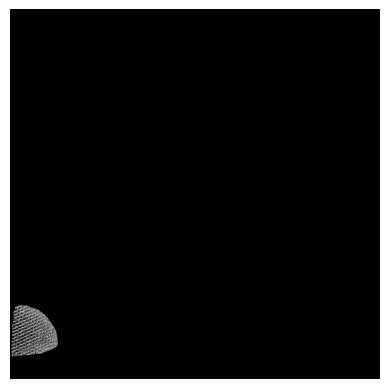

In [76]:
path = os.path.abspath("")+"/Micrographies_par_équipe"
names = listNameOfFiles(path, extension="tif")
imgs = importTIF(path)

# indice = 1 : Micrographie_6.tif
# indice = 0 : Micrographie_7.tif
# indice = 2 : Micrographie_8.tif
indice = 1

print(names[indice])
img = imgs[indice]

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.axis('off')
ax.imshow(img, cmap="gray")
plt.plot()

### Étape 2 ###
On obtient ensuite les transformées de Fourier de chaque image pour déterminer les différentes orientations et fréquences spatiales des mailles présentes sur ces images. 

[]

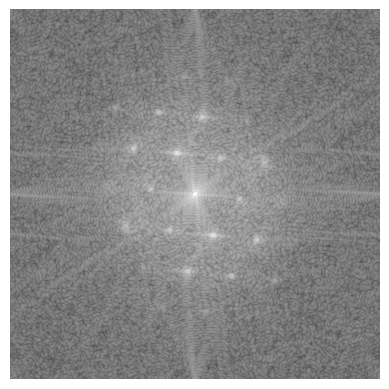

In [35]:
img_fft = np.fft.fftshift(np.fft.fft2(img))
img_fft_real = 20*np.log(abs(img_fft))

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.axis('off')
ax.imshow(img_fft_real, cmap="gray")
plt.plot()

### Étape 3 ###
On réduit maintenant le bruit de fond pour pouvoir mieux identifier les pics associés à ces orientations et fréquences.

[]

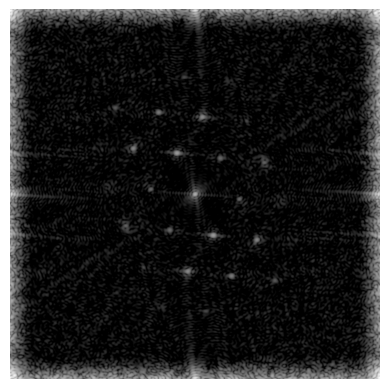

In [36]:
# On va la précalculer et l'importer puisque la convolution du filtre moyen est super lente. Pour vérifier que le résultat est pareil
# il suffit de le décommenter.
# fft_no_bg = substractBG(img_fft_real)
fft_no_bg = importTIF(path+"/FFT_NO_BG")[indice]

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.axis('off')
ax.imshow(fft_no_bg, cmap="gray")
plt.plot()

### Étape 4 ###
Un filtre OTSU est appliqué au résultat précédent pour sélectionner les pics potentiels.

[]

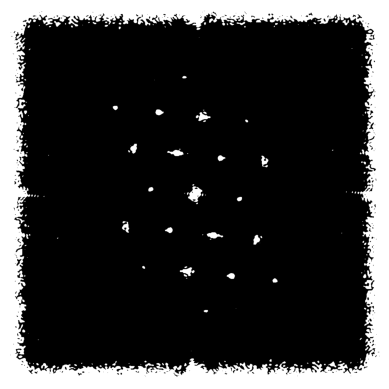

In [37]:
fft_OTSU = otsuFilter(fft_no_bg)

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.axis('off')
ax.imshow(fft_OTSU, cmap="gray")
plt.plot()

### Étape 5 ###
Les deux dernières étapes ont fait apparaitre des effets de bords qu'on retire à cette étape.

[]

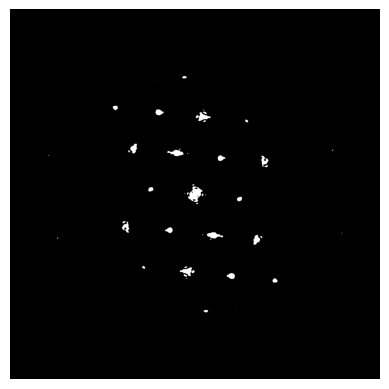

In [38]:
fft_no_border = borderEffetFilter(fft_OTSU)

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.axis('off')
ax.imshow(fft_no_border, cmap="gray")
plt.plot()

### Étape 6 ###
L'étape 6 consiste à appliquer un nouveau filtre pour obtenir des points uniformes aux endroits où sont situés des pics.

[]

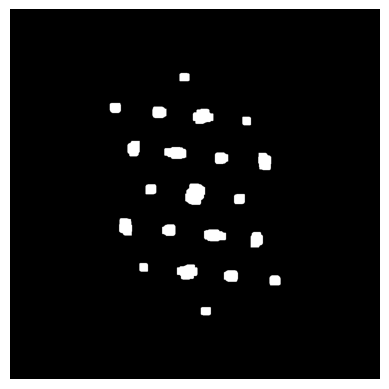

In [39]:
fft_peaks_only = noiseReductionFilter(fft_no_border, 3)

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.axis('off')
ax.imshow(fft_peaks_only, cmap="gray")
plt.plot()

### Étape 7 ###
Ensuite, on cherche à déterminer la position de chacun des pics et à les diviser en paires de points symétriques par rapport au pic central qui représente la fréquence nulle.

[]

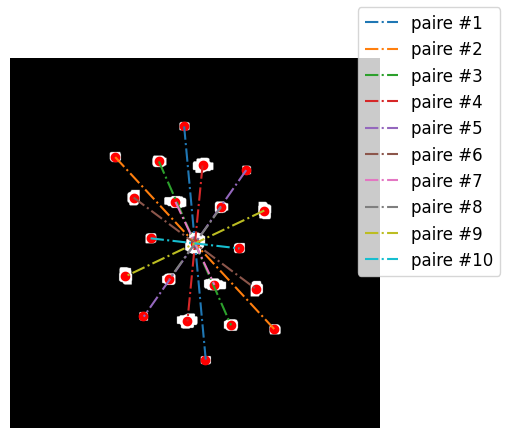

In [40]:
pos = findPos(fft_peaks_only)
pos_pairs = pairs(fft_peaks_only, pos)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(fft_peaks_only, cmap="gray")
plt.axis('off')
for yx in pos:
    y, x = yx
    ax.plot(x, y, color="r", linestyle="None", marker="o")

for i, points in enumerate(pos_pairs):
    point1, point2 = points
    ax.plot([point1[1], point2[1]], [point1[0], point2[0]], linestyle="-.", label=f"paire #{i+1}")
fig.legend(loc=1, fontsize=12)
plt.plot()

### Étape 8 ###
On crée les espaces de Fourier représentant le cosinus (la fréquence) qui nous intéresse. Cela est fait en mettant du signal à l'origine et un des points de la paire sélectionnée. Un point a été ajouté par dessus, car on ne voyait pas un unique pixel.

[]

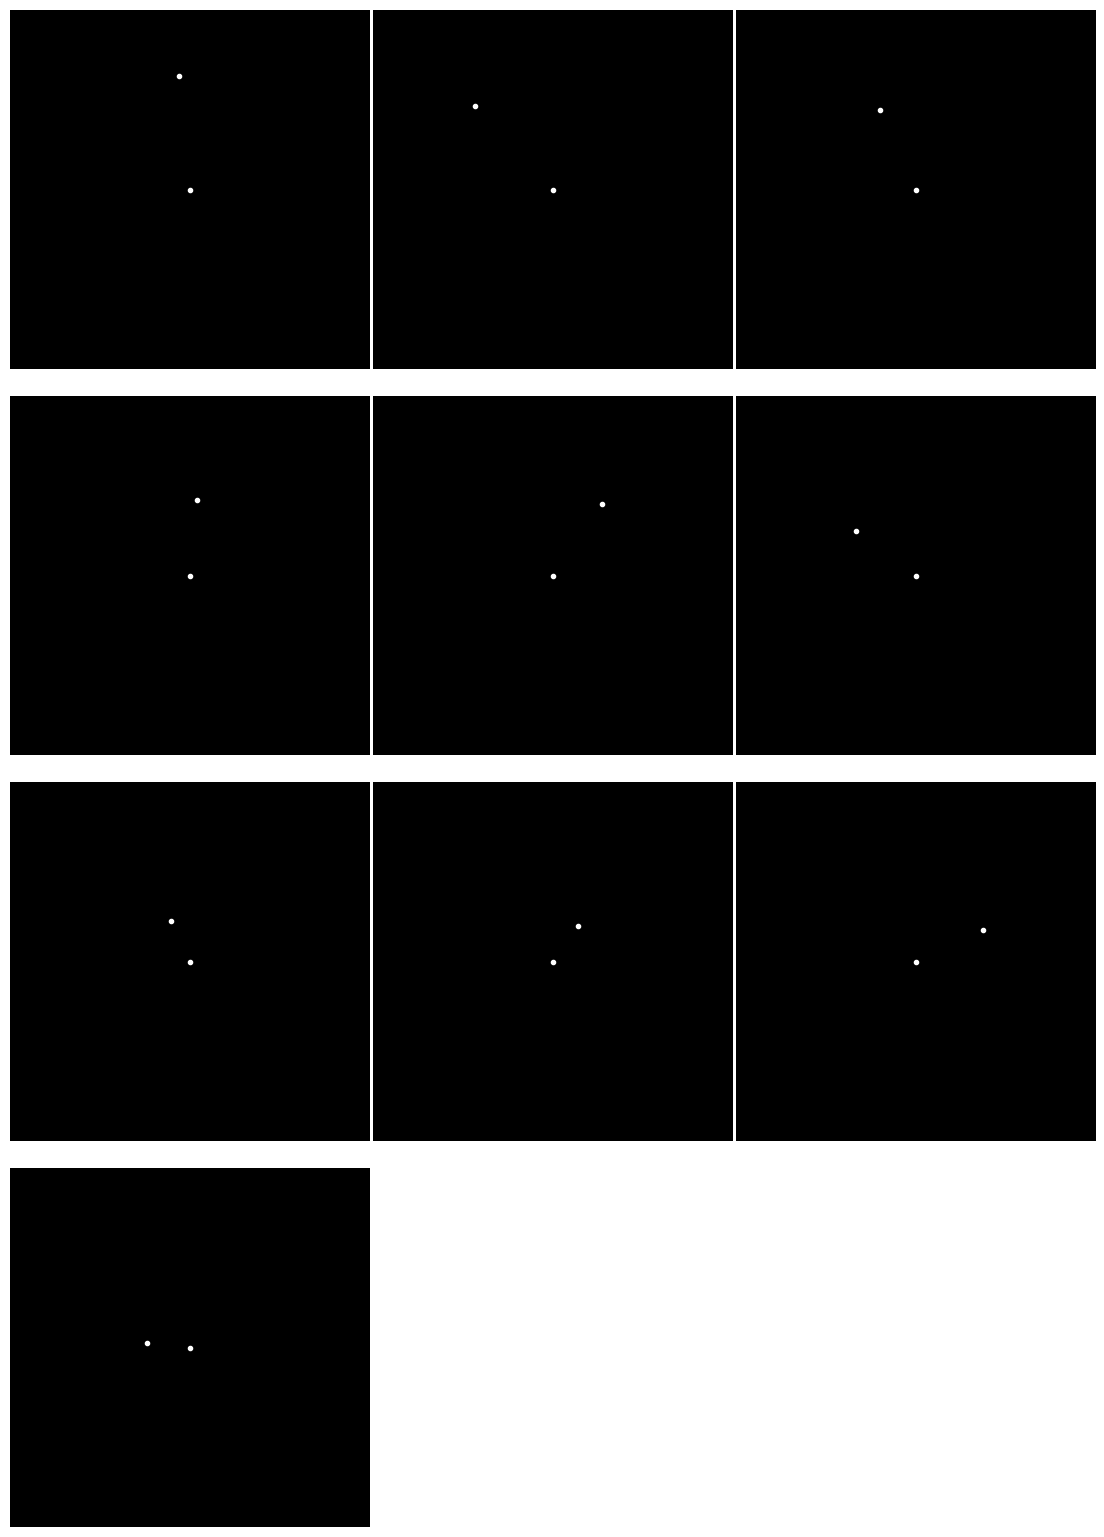

In [41]:
fft_lines, pentes = createFftDSpacing(fft_peaks_only,pos)

nb_plan = len(fft_lines)
rows = nb_plan//3
if nb_plan%3 != 0:
	rows += 1

y_mid = int(fft_peaks_only.shape[0]/2)
x_mid = int(fft_peaks_only.shape[1]/2)

fig, ax = plt.subplots(nrows=rows, ncols=3, figsize=(14,20))
plt.subplots_adjust(wspace=0.01, hspace=0.01)
for i in range(3*rows):
    y = i//3
    x = i%3
    if i >= nb_plan:
        fig.delaxes(ax[y][x])
    else:
        ax[y][x].imshow(20*np.log(abs(fft_lines[i])+1), cmap="gray")
        ax[y][x].plot(y_mid, x_mid, color="w", linestyle="None", marker=".")
        ax[y][x].plot(pos_pairs[i][0][1],pos_pairs[i][0][0], color="w", linestyle="None", marker=".")
        ax[y][x].set_axis_off()
plt.plot()

### Étape 9 ###
Une fois que nous avons sélectionné une paire de points, soit le pic central et un pic d'une paire de notre choix, on fait la transformée de Fourier inverse pour obtenir un patron régulier sur toute l'image.

[]

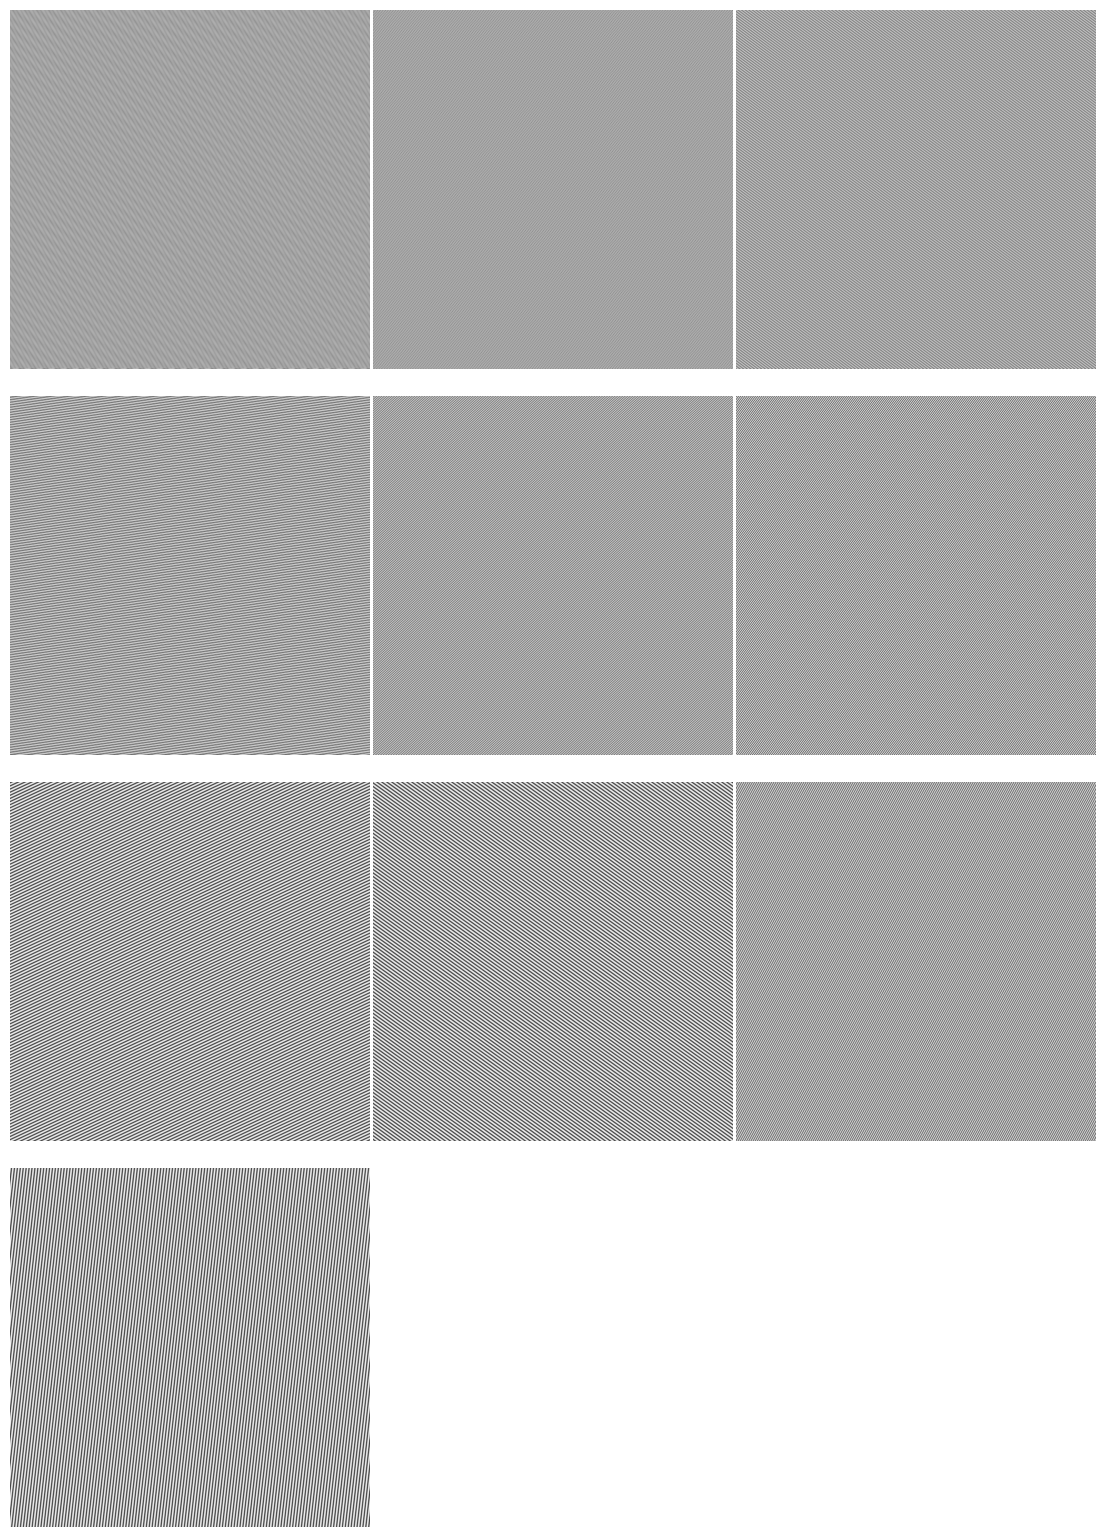

In [42]:
waves = []
for fft_line in fft_lines:
    wave = abs(np.fft.ifft2(np.fft.ifftshift(fft_line)))
    wave = (wave/np.amax(wave))*256
    wave.astype("uint8")
    waves.append(wave)

fig, ax = plt.subplots(nrows=rows, ncols=3, figsize=(14,20))
plt.subplots_adjust(wspace=0.01, hspace=0.01)
for i in range(3*rows):
    y = i//3
    x = i%3
    if i >= nb_plan:
        fig.delaxes(ax[y][x])
    else:
        ax[y][x].imshow(waves[i], cmap="gray")
        ax[y][x].set_axis_off()
plt.plot()

### Étape 10 ###
Ces patrons sont ensuite tournés pour faciliter la détection des pics.

[]

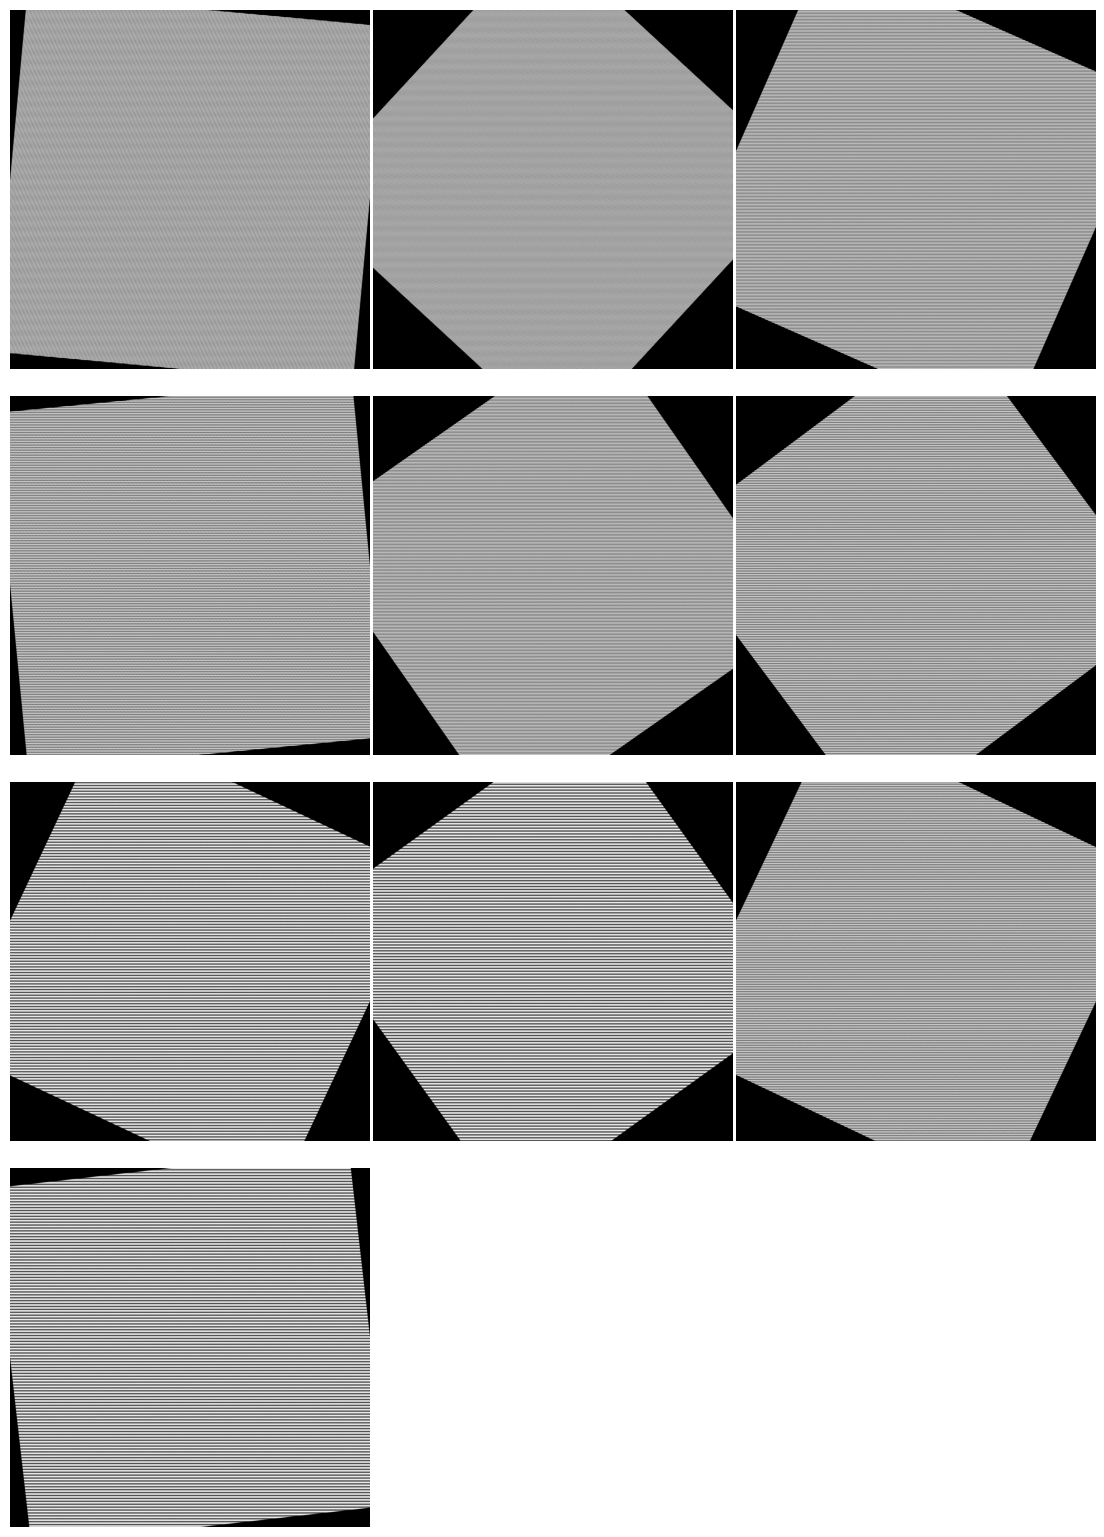

In [43]:
rotated_waves = []
for i, wave in enumerate(waves):
    theta = np.arctan(-1/pentes[i])*180/np.pi
    rotated_waves.append(rotateBy(wave, theta))

fig, ax = plt.subplots(nrows=rows, ncols=3, figsize=(14,20))
plt.subplots_adjust(wspace=0.01, hspace=0.01)
for i in range(3*rows):
    y = i//3
    x = i%3
    if i >= nb_plan:
        fig.delaxes(ax[y][x])
    else:
        ax[y][x].imshow(rotated_waves[i], cmap="gray")
        ax[y][x].set_axis_off()
plt.plot()

### Étape 11 ###
Comme le patron est régulier et horizontalement orienté, on peut prendre une coupe transversale de l'image et afficher le signal en une dimension le long de cette tranche.

[]

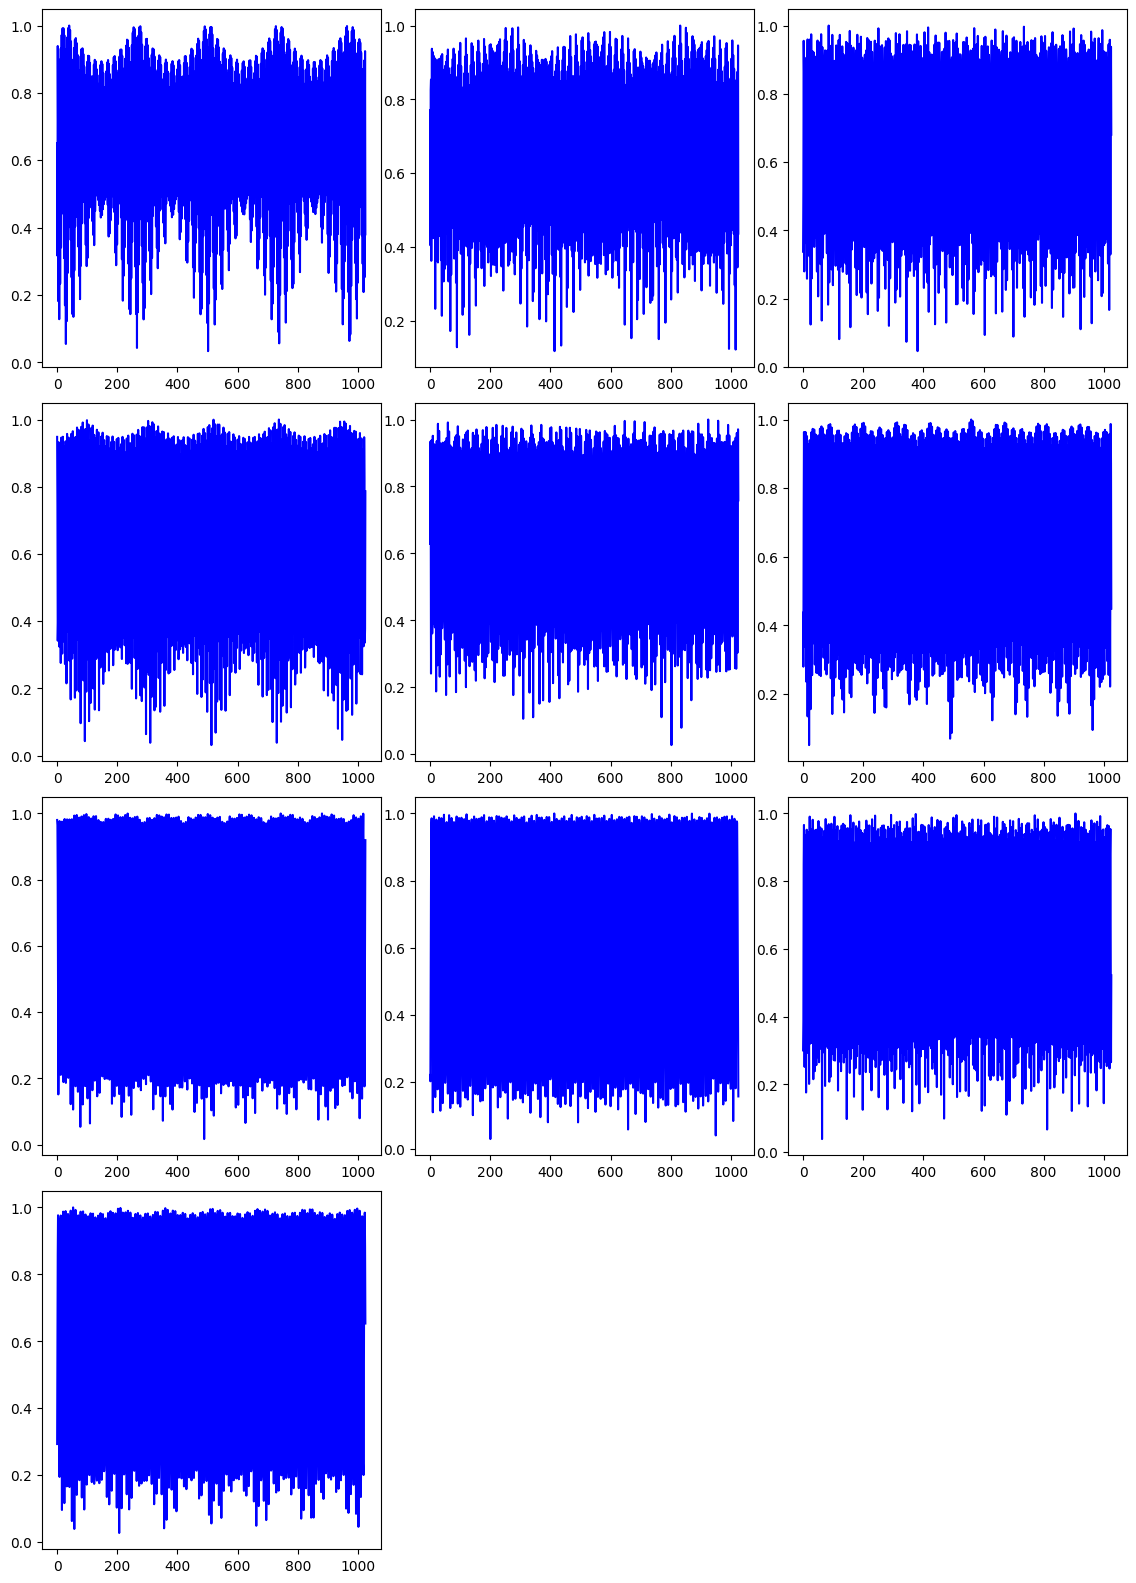

In [44]:
signals_1d = []
for rotated_wave in rotated_waves:
    signals_1d.append(rotated_wave[:,int(wave.shape[1]/2)])

signal_x = np.linspace(0,int(wave.shape[0])+1, int(wave.shape[0]))

fig, ax = plt.subplots(nrows=rows, ncols=3, figsize=(14,20))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(3*rows):
    y = i//3
    x = i%3
    if i >= nb_plan:
        fig.delaxes(ax[y][x])
    else:
        signal_y = signals_1d[i]
        signal_y = signal_y/np.amax(signal_y)
        ax[y][x].plot(signal_x, signal_y, color="b")
plt.plot()

### Étape 12 ###
Finalement, on trouve les pics présent dans ce signal et on fait la distribution de l'écart entre chaque pic. Le d_spacing associé à chaque signal se trouve à être la valeur moyenne de cette distribution et l'incertitude est l'écart-type de cette distribution.

In [75]:
import numpy as np
import scipy as sc

res = 42.468 # picomètre/pixel

d_spacings = []
incertitudes = []

def moyenne_ecart(liste):
    somme_ecarts = 0
    for i in range(len(liste) - 1):
        ecart = abs(liste[i] - liste[i + 1])
        somme_ecarts += ecart
    moyenne = somme_ecarts / (len(liste) - 1)
    return moyenne

def ecart_type(liste):
    moyenne = moyenne_ecart(liste)
    somme_carres_ecarts = 0
    for i in range(len(liste) - 1):
        ecart = abs(liste[i] - liste[i + 1])
        somme_carres_ecarts += (ecart - moyenne) ** 2
    variance = somme_carres_ecarts / (len(liste) - 1)
    ecart_type = np.sqrt(variance)
    return ecart_type

for signal_1d in signals_1d:
    peaks = sc.signal.find_peaks(signal_1d)[0]
    d_spacings.append(moyenne_ecart(peaks))
    incertitudes.append(ecart_type(peaks))

def round_to_significant(value, significant_digits=1):
    return round(value, -int(np.floor(np.log10(abs(value)))) + (significant_digits - 1))

for i, d_spacing in enumerate(d_spacings):
    spacing = round_to_significant(d_spacing)
    incertitude_pixel = round_to_significant(incertitudes[i])
    spacing_res = round_to_significant(d_spacing * res)
    incertitude_res = round_to_significant(incertitudes[i] * res)
    
    spacing_str = "{:.{prec}f}".format(spacing, prec=max(0, -int(np.floor(np.log10(abs(spacing))))) + 1)
    incertitude_pixel_str = "{:.1f}".format(incertitude_pixel) 
    spacing_res_str = "{:.0f}".format(spacing_res) if spacing_res != float('inf') else 'inf'  
    incertitude_res_str = "{:.0f}".format(incertitude_res)  
    
    if i < 9:
        print("0"+str(i+1), " | ", spacing_str, "±", incertitude_pixel_str, "  [px] |", spacing_res_str, "±", incertitude_res_str, "[pm]")
    else:
        print(i+1, " | ", spacing_str, "±", incertitude_pixel_str, "  [px] |", spacing_res_str, "±", incertitude_res_str, "[pm]")



01  |  3.0 ± 0.4   [px] | 100 ± 20 [pm]
02  |  3.0 ± 0.4   [px] | 100 ± 10 [pm]
03  |  4.0 ± 0.3   [px] | 200 ± 10 [pm]
04  |  5.0 ± 0.5   [px] | 200 ± 20 [pm]
05  |  4.0 ± 0.3   [px] | 200 ± 10 [pm]
06  |  5.0 ± 0.4   [px] | 200 ± 20 [pm]
07  |  8.0 ± 0.2   [px] | 300 ± 10 [pm]
08  |  8.0 ± 0.5   [px] | 400 ± 20 [pm]
09  |  5.0 ± 0.4   [px] | 200 ± 20 [pm]
10  |  8.0 ± 0.4   [px] | 400 ± 20 [pm]


# Médiagraphie #

 <a href="https://www.dyerga.org/blog/2019/12/14/tem-d-spacings/"> Méthode "à la main" </a>

<a href="https://www.umsl.edu/~fraundorfp/rose/Thesis_Martin_Rose.pdf"> Indice de Miller </a>

<a href="https://link.springer.com/article/10.1007/s41871-022-00129-7"> Méthode par transformée de fourier </a>